In [5]:
import pandas as pd
import numpy as np
import os

os.chdir('/Users/rajesh/downloads')
os.getcwd()

'/Users/rajesh/Downloads'

In [37]:
#read historical prices of 4 stocks: Amazon, IBM, Apple & Tesla

amzn = pd.read_csv('AMZN.csv')
ibm = pd.read_csv('IBM.csv')
aapl = pd.read_csv('AAPL.csv')
tsla = pd.read_csv('TSLA.csv')
tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-02,48.299999,48.638000,46.964001,48.360001,48.360001,19219500
1,2016-05-03,47.472000,47.782001,46.324001,46.464001,46.464001,21511000
2,2016-05-04,46.057999,46.891998,44.080002,44.512001,44.512001,43502500
3,2016-05-05,45.692001,45.728001,41.958000,42.306000,42.306000,56274000
4,2016-05-06,42.174000,43.273998,41.622002,42.986000,42.986000,28426000


In [41]:
#Take only Date & Close prices, delete other columns
amzn = amzn[['Date', 'Close']]
ibm = ibm[['Date', 'Close']]
aapl = aapl[['Date', 'Close']]
tsla = tsla[['Date', 'Close']]
tsla.head()

,Date,Close
0,2016-05-02,48.360001
1,2016-05-03,46.464001
2,2016-05-04,44.512001
3,2016-05-05,42.306000
4,2016-05-06,42.986000


In [56]:
#merge all dataframes into 1
df = pd.merge(amzn,ibm, how = 'inner', on = 'Date')
df = pd.merge(df, aapl, how = 'inner', on = 'Date')
df = pd.merge(df, tsla, how = 'inner', on = 'Date')
df.head()

,Date,Close_x,Close_y,Close_x,Close_y
0,2016-05-02,683.849976,145.270004,23.410000,48.360001
1,2016-05-03,671.320007,144.130005,23.795000,46.464001
2,2016-05-04,670.900024,144.250000,23.547501,44.512001
3,2016-05-05,659.090027,146.470001,23.309999,42.306000
4,2016-05-06,673.950012,147.289993,23.180000,42.986000


In [61]:
df = df.rename(columns = {'Close_x':'AMZN', 'CLose_y':'IBM', 'CLose_x':'AAPL','Close_y': 'TSLA'})
df.set_index('Date', inplace = True)
df.head()

,AMZN,TSLA,AMZN,TSLA
Date,,,,
2016-05-02,683.849976,145.270004,23.410000,48.360001
2016-05-03,671.320007,144.130005,23.795000,46.464001
2016-05-04,670.900024,144.250000,23.547501,44.512001
2016-05-05,659.090027,146.470001,23.309999,42.306000
2016-05-06,673.950012,147.289993,23.180000,42.986000


In [77]:
#calculate 1 day log returns of stocks
log_ret = np.log(df/df.shift(1))
log_ret.dropna(inplace = True)
log_ret.head()

,AMZN,TSLA,AMZN,TSLA
Date,,,,
2016-05-03,-0.018493,-0.007878,0.016312,-0.039995
2016-05-04,-0.000626,0.000832,-0.010456,-0.042919
2016-05-05,-0.017760,0.015273,-0.010137,-0.050830
2016-05-06,0.022296,0.005583,-0.005593,0.015946
2016-05-09,0.008569,0.000339,0.000755,-0.028361


In [83]:
#simulate sharpe ratios for 5000 random portfolio weightages
np.random.seed(45)
rfr = 0.02
num_ports = 5000
weights = np.zeros((num_ports, len(df.columns)))
all_weights = np.zeros((num_ports, len(df.columns)))
vol_arr = np.zeros(num_ports)
ret_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for i in range(num_ports):
    weights = np.random.random(4)
    weights = weights/sum(weights)
    all_weights[i,:] = weights
    ret_arr[i] = sum(log_ret.mean()*weights*252)
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sharpe_arr[i] =  (ret_arr[i] - rfr)/vol_arr[i]

print('The highest Sharpe Ratio obtained is: {}'.format(sharpe_arr.max()))
print('The location in the array is: {}'.format(sharpe_arr.argmax()))

The highest Sharpe Ratio obtained is: 1.2384280118086644
The location in the array is: 3364


In [84]:
#get the weightages of stocks corresponding to maximum sharpe ratio
print(all_weights[3364])


[0.43905895 0.00506799 0.41885771 0.13701534]


In [85]:
import matplotlib.pyplot as plt

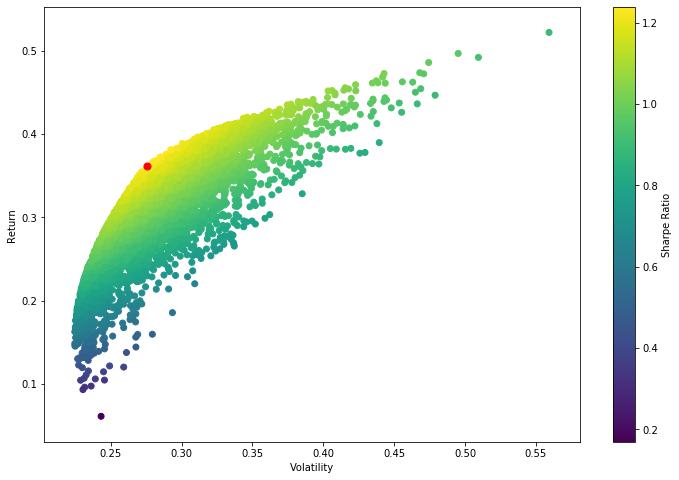

In [93]:
plt.figure(figsize = (12,8))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap = 'viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol_arr[sharpe_arr.argmax()], ret_arr[sharpe_arr.argmax()], c = 'r', s=50) #plot max sharpe ratio

In [131]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = sum(log_ret.mean()*weights)*252
    vol = np.sqrt(np.dot(weights.T, (np.dot(log_ret.cov()*252,weights))))
    sr = (ret - rfr)/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2]*-1

def check_sum(weights):
    return sum(weights) - 1

In [132]:
cons = ({'type':'eq', 'fun': check_sum})
bounds = ((0,1), (0,1), (0,1), (0,1))
init_guess = [0.25, 0.25, 0.25, 0.25]

In [133]:
from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds = bounds, constraints = cons)
opt_results

     fun: -1.2436723295629228
     jac: array([-0.07112645,  0.52998105, -0.07112862, -0.07112901])
 message: 'Optimization terminated successfully.'
    nfev: 31
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([4.11356172e-01, 2.87839060e-16, 4.19904335e-01, 1.68739492e-01])

In [134]:
get_ret_vol_sr(opt_results.x)

array([0.36970071, 0.28118396, 1.24367233])

In [135]:
#build efficient frontier
frontier_y = np.linspace(0, 0.55, 200)

In [136]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [137]:
frontier_x=[]
sharpe_array=[]
for i in range(len(frontier_y)):
    cons = ({'type':'eq', 'fun':check_sum},
           {'type':'eq', 'fun': lambda w:get_ret_vol_sr(w)[0] - frontier_y[i]})
    opt_results = minimize (minimize_volatility, init_guess, method = 'SLSQP', bounds = bounds, constraints = cons)
    frontier_x.append(opt_results['fun'])
    sharpe_array.append( (frontier_y[i] - rfr)/opt_results['fun'] )

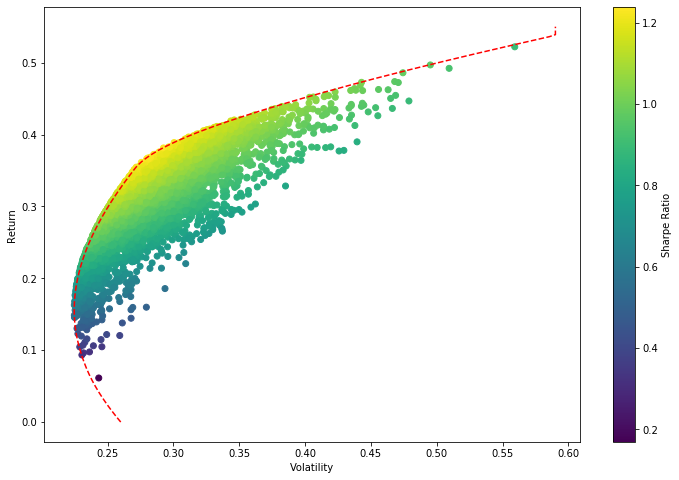

In [138]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap='viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--')